<a href="https://colab.research.google.com/github/Shelly10-10/flood_prediction/blob/main/disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📌 Step 1: Import libraries and upload the dataset
import pandas as pd
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

uploaded = files.upload()

# 📌 Step 2: Load the dataset
df = pd.read_csv('merged_dataset_final_renamed.csv', encoding='ISO-8859-1')  # Try changing encoding if needed

# 📌 Step 3: Basic Info
print("Shape of dataset:", df.shape)
print("Column names:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nFirst few rows:\n", df.head())

# 📌 Step 4: Handle missing values (you can modify this)
df.fillna(method='ffill', inplace=True)  # Forward fill for missing values

# 📌 Step 5: Check duplicates but DON'T DROP
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows (not dropped): {duplicate_rows}")

# 📌 Step 6: Convert datetime column (if present)
if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'], errors='coerce')

# 📌 Step 7: Normalize numeric features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# 📌 Step 8: Encode categorical columns (if any)
for col in df.select_dtypes(include='object').columns:
    if col != 'time':  # Skip datetime
        df[col] = df[col].astype('category').cat.codes

# 📌 Step 9: Split into features and label (Replace 'target_column' with actual target)
# Example: if you're predicting 'flood_occurred' column
# df['flood_occurred'] = df['flood_occurred'].astype(int)
# X = df.drop('flood_occurred', axis=1)
# y = df['flood_occurred']

# Temporary placeholder to avoid crash
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 Step 10: Save cleaned data
df.to_csv('cleaned_dataset.csv', index=False)
print("\n✅ Data preprocessing complete. Cleaned data saved as 'cleaned_dataset.csv'")
from google.colab import files
files.download('cleaned_dataset.csv')



Saving merged_dataset_final_renamed.csv to merged_dataset_final_renamed.csv
Shape of dataset: (1048575, 17)
Column names: ['valid_time', 'latitude', 'longitude', 'number', 'Experiment Version', 'Total Precipitation (mm)', 'Evaporation (mm)', 'Surface Runoff (mm)', 'Mean Wave Direction (°)', '10m U-Component of Wind (m/s)', '10m V-Component of Wind (m/s)', '2m Temperature', 'Mean Sea Level (°C)', 'Sea Surface Temperature (°C)', 'Soil Temperature Level 1 (°C)', 'Soil Type', 'Soil Water Volume Level 1 (m³/m³)']

Data Types:
 valid_time                            object
latitude                             float64
longitude                            float64
number                                 int64
Experiment Version                     int64
Total Precipitation (mm)             float64
Evaporation (mm)                     float64
Surface Runoff (mm)                  float64
Mean Wave Direction (°)              float64
10m U-Component of Wind (m/s)        float64
10m V-Component of Win

/tmp/ipython-input-3-2780356005.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill for missing values



Number of duplicate rows (not dropped): 0

✅ Data preprocessing complete. Cleaned data saved as 'cleaned_dataset.csv'


In [ ]:
from google.colab import files
files.download('cleaned_dataset.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
df = pd.read_csv('merged_dataset_final_renamed.csv', encoding='ISO-8859-1')


In [ ]:
df['Total Precipitation (mm)'].describe()


,Total Precipitation (mm)
count,26491.000000
mean,0.229548
std,0.846150
min,0.000000
25%,0.000000
50%,0.000000
75%,0.047700
max,27.039528


In [ ]:
df['valid_time'] = pd.to_datetime(df['valid_time'], dayfirst=True)


In [ ]:
df_daily = df.groupby([
    df['valid_time'].dt.date,
    'latitude',
    'longitude'
]).agg({
    'Total Precipitation (mm)': 'sum',
    'Evaporation (mm)': 'mean',
    'Surface Runoff (mm)': 'sum',
    'Mean Wave Direction (°)': 'mean',
    '10m U-Component of Wind (m/s)': 'mean',
    '10m V-Component of Wind (m/s)': 'mean',
    '2m Temperature': 'mean',
    'Mean Sea Level (°C)': 'mean',
    'Sea Surface Temperature (°C)': 'mean',
    'Soil Temperature Level 1 (°C)': 'mean',
    'Soil Type': 'first',  # assuming fixed per location
    'Soil Water Volume Level 1 (m³/m³)': 'mean',
    'number': 'first',
    'Experiment Version': 'first'
}).reset_index()


In [ ]:
df_daily.fillna({
    'Total Precipitation (mm)': 0,
    'Evaporation (mm)': df_daily['Evaporation (mm)'].mean(),
    'Surface Runoff (mm)': 0,
    'Mean Wave Direction (°)': df_daily['Mean Wave Direction (°)'].mean(),
    '10m U-Component of Wind (m/s)': df_daily['10m U-Component of Wind (m/s)'].mean(),
    '10m V-Component of Wind (m/s)': df_daily['10m V-Component of Wind (m/s)'].mean(),
    '2m Temperature': df_daily['2m Temperature'].mean(),
    'Mean Sea Level (°C)': df_daily['Mean Sea Level (°C)'].mean(),
    'Sea Surface Temperature (°C)': df_daily['Sea Surface Temperature (°C)'].mean(),
    'Soil Temperature Level 1 (°C)': df_daily['Soil Temperature Level 1 (°C)'].mean(),
    'Soil Type': df_daily['Soil Type'].mode()[0],
    'Soil Water Volume Level 1 (m³/m³)': df_daily['Soil Water Volume Level 1 (m³/m³)'].mean()
}, inplace=True)


In [ ]:
precip_high = df_daily['Total Precipitation (mm)'] > df['Total Precipitation (mm)'].quantile(0.75)
runoff_high = df_daily['Surface Runoff (mm)'] > df['Surface Runoff (mm)'].quantile(0.75)
evap_low = df_daily['Evaporation (mm)'] < df['Evaporation (mm)'].quantile(0.25)
soil_saturated = df_daily['Soil Water Volume Level 1 (m³/m³)'] > 0.22
bad_soil = df_daily['Soil Type'].isin([3, 4, 5])  # modify based on your soil legend
wind_active = (abs(df_daily['10m U-Component of Wind (m/s)']) > 2) | (abs(df['10m V-Component of Wind (m/s)']) > 2)
sea_warm = df_daily['Sea Surface Temperature (°C)'] > df['Sea Surface Temperature (°C)'].quantile(0.75)



In [ ]:
df_daily['Flood_Occurred'] = (
    (
        precip_high & runoff_high & soil_saturated
    ) |
    (
        precip_high & evap_low & bad_soil
    ) |
    (
        runoff_high & wind_active & sea_warm
    )
).astype(int)


In [ ]:
print(df_daily['Flood_Occurred'].value_counts())

Flood_Occurred
0    10382
1     3059
Name: count, dtype: int64


In [ ]:
df_daily.head(10)

,valid_time,latitude,longitude,Total Precipitation (mm),Evaporation (mm),Surface Runoff (mm),Mean Wave Direction (°),10m U-Component of Wind (m/s),10m V-Component of Wind (m/s),2m Temperature,Mean Sea Level (°C),Sea Surface Temperature (°C),Soil Temperature Level 1 (°C),Soil Type,Soil Water Volume Level 1 (m³/m³),number,Experiment Version,Flood_Occurred
0,2019-06-01,17.0,80.00,0.754356,-0.000077,0.00381,191.530016,-0.432724,0.391968,306.955200,100267.030,302.927927,310.633910,3.0,0.141076,0,1,0
1,2019-06-01,17.0,80.25,0.000000,-0.000080,0.00000,191.530016,-0.372177,0.942261,307.118300,100264.845,302.927927,310.503050,3.0,0.155663,0,1,0
2,2019-06-01,17.0,80.50,0.001430,-0.000083,0.00000,191.530016,-0.260361,1.416382,306.941530,100271.280,302.927927,309.777470,4.0,0.194566,0,1,0
3,2019-06-01,17.0,80.75,0.005720,-0.000074,0.00000,191.530016,-0.365341,1.589722,306.190550,100287.905,302.927927,308.580200,4.0,0.264169,0,1,0
4,2019-06-01,17.0,81.00,0.000000,-0.000080,0.00000,191.530016,-0.611435,1.629272,306.072390,100296.030,302.927927,307.952270,4.0,0.270448,0,1,0
5,2019-06-01,17.0,81.25,0.009540,-0.000084,0.00000,191.530016,-0.615829,1.212280,306.314575,100289.280,302.927927,308.391725,4.0,0.252602,0,1,0
6,2019-06-01,17.0,81.50,0.005720,-0.000085,0.00000,191.530016,-0.370224,1.239136,306.444450,100279.780,302.927927,308.638790,4.0,0.258607,0,1,0
7,2019-06-01,17.0,81.75,0.001910,-0.000086,0.00000,191.530016,-0.345810,1.630249,307.045035,100276.345,302.927927,309.271605,3.0,0.170922,0,1,0
8,2019-06-01,17.0,82.00,0.000477,-0.000063,0.00000,191.530016,-0.783310,2.411499,306.698365,100291.405,302.927927,309.200320,4.0,0.199319,0,1,0
9,2019-06-01,17.0,82.25,0.003810,-0.000042,0.00000,191.530016,-1.113388,3.781616,304.482545,100312.220,302.927927,305.946410,4.0,0.143288,0,1,0


In [ ]:
df_daily.to_csv('labelled_dataset_flood1.csv', index=False)


In [ ]:
from google.colab import files
files.download('labelled_dataset_flood1.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd
df=pd.read_csv("labelled_dataset_flood1.csv")
print(df['Flood_Occurred'].value_counts())

Flood_Occurred
0    10382
1     3059
Name: count, dtype: int64


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("labelled_dataset_flood1.csv")

# Drop unnecessary columns like 'Experiment Version', 'number'
df = df.drop(columns=['Experiment Version', 'number'])

# Sort by date
df['valid_time'] = pd.to_datetime(df['valid_time'])
df = df.sort_values('valid_time')

# Normalize features (except label)
scaler = MinMaxScaler()
features = df.drop(columns=['Flood_Occurred', 'valid_time']).columns
df[features] = scaler.fit_transform(df[features])


In [3]:
import numpy as np

window_size = 7  # 7 days to predict flood on day 8
X, y = [], []

for i in range(len(df) - window_size):
    seq = df.iloc[i:i+window_size]
    X.append(seq[features].values)
    y.append(df.iloc[i+window_size]['Flood_Occurred'])

X = np.array(X)
y = np.array(y)


In [4]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, GlobalAveragePooling1D

inputs = Input(shape=(X.shape[1], X.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(inputs)

# Add attention mechanism
attention = tf.keras.layers.Attention()([lstm_out, lstm_out])
context = GlobalAveragePooling1D()(attention)
dense = Dense(32, activation='relu')(context)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs, output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 64)     │     20,224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 7, 64)     │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, class_weight=class_weights)


Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6764 - loss: 0.6082 - val_accuracy: 0.8028 - val_loss: 0.4823
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7699 - loss: 0.5050 - val_accuracy: 0.8037 - val_loss: 0.4572
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7757 - loss: 0.4805 - val_accuracy: 0.8344 - val_loss: 0.4023
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7837 - loss: 0.4762 - val_accuracy: 0.8419 - val_loss: 0.3649
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7834 - loss: 0.4734 - val_accuracy: 0.8363 - val_loss: 0.4044
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7988 - loss: 0.4429 - val_accuracy: 0.8130 - val_loss: 0.4308
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7952 - loss: 0.4487 - val_accuracy: 0.7665 - val_loss: 0.4995
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7798 - loss: 0.4609 - val_accuracy: 0.

In [8]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred))


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      2076
           1       0.61      0.75      0.67       611

    accuracy                           0.83      2687
   macro avg       0.77      0.81      0.78      2687
weighted avg       0.85      0.83      0.84      2687



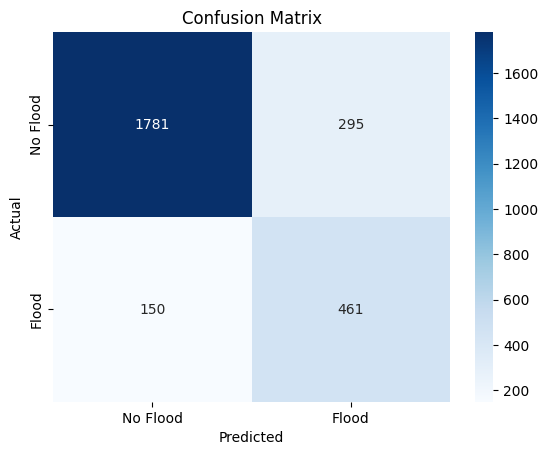

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [10]:
print(X.shape)


(13434, 7, 14)


In [11]:
from sklearn.preprocessing import StandardScaler
import numpy as np

X_scaled = np.empty_like(X)  # create empty array with same shape

for feature in range(X.shape[2]):  # loop over each of the 14 features
    scaler = StandardScaler()
    # Reshape to 2D: (samples*time_steps, 1)
    feature_data = X[:, :, feature].reshape(-1, 1)
    # Scale and reshape back
    scaled_feature = scaler.fit_transform(feature_data).reshape(X.shape[0], X.shape[1])
    X_scaled[:, :, feature] = scaled_feature


In [12]:
X_flat = X_scaled.reshape((X_scaled.shape[0], -1))  # shape: (13434, 7×14 = 98)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_flat, y)


In [13]:
# ✅ Full Attention RNN Model Pipeline for Flood Prediction

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, GlobalAveragePooling1D
from sklearn.metrics import classification_report

# ---------------------- Step 1: Load and Prepare Dataset ----------------------
df = pd.read_csv("labelled_dataset_flood1.csv")

# Ensure datetime column
df['valid_time'] = pd.to_datetime(df['valid_time'])

# Sort by time to maintain sequential order
df = df.sort_values(by='valid_time')

# ---------------------- Step 2: Prepare Features and Target -------------------
target = df['Flood_Occurred']
features = df.drop(['valid_time', 'Flood_Occurred'], axis=1)

# ---------------------- Step 3: Normalize Features ----------------------------
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# ---------------------- Step 4: Create Sequences ------------------------------
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(features_scaled, target, time_steps=7)

# ---------------------- Step 5: Train-Test Split ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42)

# ---------------------- Step 6: SMOTE Oversampling ----------------------------
n_samples, time_steps, n_features = X_train.shape
X_train_flat = X_train.reshape((n_samples, time_steps * n_features))

sm = SMOTE(random_state=42)
X_res_flat, y_res = sm.fit_resample(X_train_flat, y_train)

X_res = X_res_flat.reshape((-1, time_steps, n_features))

# ---------------------- Step 7: Build Attention RNN Model ---------------------
input_layer = Input(shape=(time_steps, n_features))
x = LSTM(64, return_sequences=True)(input_layer)
x = Attention()([x, x])
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ---------------------- Step 8: Train Model -----------------------------------
history = model.fit(X_res, y_res, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# ---------------------- Step 9: Evaluate Model -------------------------------
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))


Epoch 1/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7146 - loss: 0.5596 - val_accuracy: 0.6747 - val_loss: 0.6164
Epoch 2/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7822 - loss: 0.4617 - val_accuracy: 0.7830 - val_loss: 0.4615
Epoch 3/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7916 - loss: 0.4441 - val_accuracy: 0.8188 - val_loss: 0.4092
Epoch 4/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8018 - loss: 0.4326 - val_accuracy: 0.7845 - val_loss: 0.4460
Epoch 5/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8056 - loss: 0.4273 - val_accuracy: 0.8340 - val_loss: 0.3778
Epoch 6/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8095 - loss: 0.4204 - val_accuracy: 0.8109 - val_loss: 0.4110
Epoch 7/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8122 - loss: 0.4162 - val_accuracy: 0.8336 - val_loss: 0.3772
Epoch 8/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8103 - loss: 0.4210 - val_accuracy: 0.

Epoch 1/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7331 - loss: 0.5286 - precision: 0.7266 - recall: 0.7479 - val_accuracy: 0.8025 - val_loss: 0.4340 - val_precision: 0.8090 - val_recall: 0.8013
Epoch 2/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7952 - loss: 0.4375 - precision: 0.7968 - recall: 0.7894 - val_accuracy: 0.8311 - val_loss: 0.4022 - val_precision: 0.8367 - val_recall: 0.8303
Epoch 3/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8190 - loss: 0.3970 - precision: 0.8209 - recall: 0.8186 - val_accuracy: 0.8344 - val_loss: 0.3818 - val_precision: 0.8284 - val_recall: 0.8510
Epoch 4/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8321 - loss: 0.3770 - precision: 0.8216 - recall: 0.8406 - val_accuracy: 0.8458 - val_loss: 0.3717 - val_precision: 0.8398 - val_recall: 0.8616
Epoch 5/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8442 - loss: 0.3565 - precision: 0.8335 - recall: 0.8546 - val_accuracy: 0.8497 - val_loss: 0.

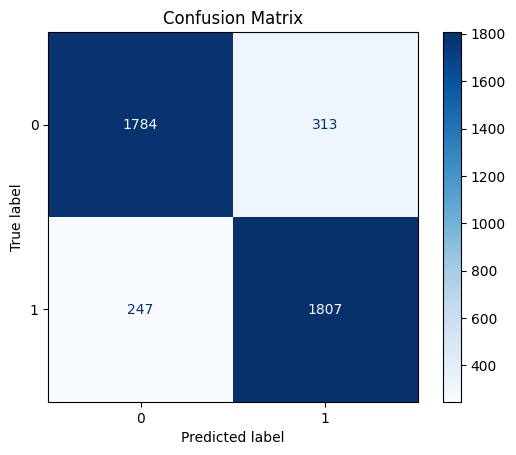

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Flatten

# ---------------------------------------------
# Step 1: Standardize Each Feature (Keep Shape)
# ---------------------------------------------
X_scaled = np.empty_like(X)
for i in range(X.shape[2]):
    scaler = StandardScaler()
    X_scaled[:, :, i] = scaler.fit_transform(X[:, :, i])

# ---------------------------------------------
# Step 2: Flatten for SMOTE
# ---------------------------------------------
X_flat = X_scaled.reshape((X_scaled.shape[0], -1))  # (13434, 98)

# ---------------------------------------------
# Step 3: Apply SMOTE
# ---------------------------------------------
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_flat, y)

# ---------------------------------------------
# Step 4: Reshape back for LSTM (3D)
# ---------------------------------------------
X_res_lstm = X_res.reshape((-1, 7, 14))

# ---------------------------------------------
# Step 5: Train/Test Split
# ---------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res_lstm, y_res, test_size=0.2, random_state=42)

# ---------------------------------------------
# Step 6: Attention LSTM Model
# ---------------------------------------------
inputs = Input(shape=(7, 14))
lstm_out = LSTM(64, return_sequences=True)(inputs)
context = Attention()([lstm_out, lstm_out])  # Attention layer
concat = Concatenate()([context, lstm_out])
flat = Flatten()(concat)
output = Dense(1, activation='sigmoid')(flat)

model = Model(inputs, output)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# ---------------------------------------------
# Step 7: Train
# ---------------------------------------------
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2)

# ---------------------------------------------
# Step 8: Predict and Evaluate
# ---------------------------------------------
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


Epoch 1/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7736 - loss: 0.4812 - precision_1: 0.7703 - recall_1: 0.7871 - val_accuracy: 0.8196 - val_loss: 0.4062 - val_precision_1: 0.8149 - val_recall_1: 0.8356 - learning_rate: 0.0010
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8177 - loss: 0.4094 - precision_1: 0.8101 - recall_1: 0.8276 - val_accuracy: 0.8317 - val_loss: 0.3971 - val_precision_1: 0.8591 - val_recall_1: 0.8007 - learning_rate: 0.0010
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8288 - loss: 0.3836 - precision_1: 0.8256 - recall_1: 0.8315 - val_accuracy: 0.8356 - val_loss: 0.3896 - val_precision_1: 0.8175 - val_recall_1: 0.8717 - learning_rate: 0.0010
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8380 - loss: 0.3700 - precision_1: 0.8265 - recall_1: 0.8550 - val_accuracy: 0.8479 - val_loss: 0.3620 - val_precision_1: 0.8294 - val_recall_1: 0.8829 - learning_rate: 0.0010
Epoch 5/50
208/208 ━━━━━━━━━

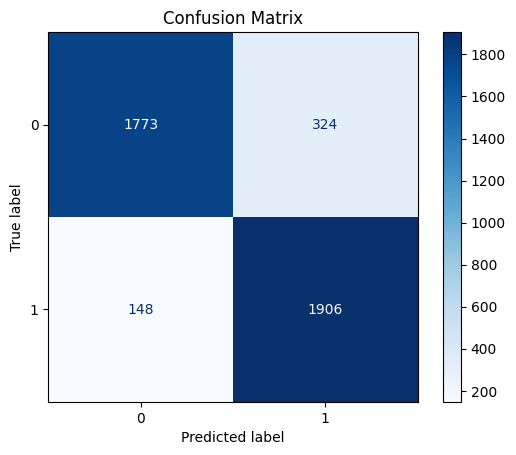

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Flatten, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ---------------------------------------------
# Step 1: Feature Scaling
# ---------------------------------------------
X_scaled = np.empty_like(X)
for i in range(X.shape[2]):
    scaler = StandardScaler()
    X_scaled[:, :, i] = scaler.fit_transform(X[:, :, i])

# ---------------------------------------------
# Step 2: SMOTE Oversampling
# ---------------------------------------------
X_flat = X_scaled.reshape((X_scaled.shape[0], -1))
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_flat, y)
X_res_lstm = X_res.reshape((-1, 7, 14))

# ---------------------------------------------
# Step 3: Train-Test Split
# ---------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res_lstm, y_res, test_size=0.2, random_state=42)

# ---------------------------------------------
# Step 4: Model Architecture (Upgraded)
# ---------------------------------------------
inputs = Input(shape=(7, 14))

# Bidirectional LSTM
x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
x = Dropout(0.3)(x)

# Attention Layer
attention = Attention()([x, x])
x = Concatenate()([x, attention])

# Dense layers
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs, output)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# ---------------------------------------------
# Step 5: Callbacks for Smart Training
# ---------------------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# ---------------------------------------------
# Step 6: Model Training
# ---------------------------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ---------------------------------------------
# Step 7: Evaluation
# ---------------------------------------------
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Metrics
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [20]:
#APPROACH-4
# 🧩 STEP 1: Imports and Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
import shap
import matplotlib.pyplot as plt

# 📦 Check versions
print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)
print("SHAP:", shap.__version__)

# 🧪 Simulated dataset (replace with your actual data)
# X shape: (samples, timesteps, features), y shape: (samples,)
# For example: X.shape = (13434, 7, 14)
# Make sure X and y are already loaded before this cell
# ------------------------
# X = np.array(...)  # Your data
# y = np.array(...)  # Labels (0 or 1)
# ------------------------

# 🧩 STEP 2: Flatten for SMOTE (only during balancing)
X_flat = X.reshape(X.shape[0], -1)

# 🔄 STEP 3: Class Balancing
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_flat_scaled, y)

# 🧩 STEP 4: Reshape back to 3D for LSTM
X_resampled_3d = X_resampled.reshape(-1, 7, 14)

# ✂️ STEP 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_3d, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# 🧠 STEP 6: Build BiLSTM Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(7, 14)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 🚀 STEP 7: Train
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# 📈 STEP 8: Evaluate
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred_binary))

# 🧠 STEP 9: SHAP Explainability
# Use RandomForest with flattened features to interpret (SHAP does not support 3D input)
from sklearn.ensemble import RandomForestClassifier

# Use same flattened + scaled data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_flat_scaled, y)

explainer = shap.Explainer(rf, X_flat_scaled)
shap_values = explainer(X_flat_scaled[:100])

# 📊 SHAP Beeswarm Plot
shap.plots.beeswarm(shap_values)

# 📝 Optional: Save model if needed
# model.save('flood_detection_model.h5')



NumPy: 2.0.2
TensorFlow: 2.18.0
SHAP: 0.48.0


AttributeError: 'DataFrame' object has no attribute 'reshape'

In [17]:
# ✅ Step 1: Load dataset
df = pd.read_csv('labelled_dataset_flood1.csv')  # replace with your actual dataset


In [18]:
#first time took the timesteps=16 and got the accuracy 93% this time took the timestamp=10 and reduced the batch size to 32 and got the accuracy 96%

In [22]:
# 📦 Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import shap
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Step 2: Drop non-numeric or unwanted columns (like timestamp, IDs)
df = df.drop(columns=['valid_time'])  # drop timestamp etc.

# ✅ Step 3: Features & Target
target_col = 'Flood_Occurred'
X = df.drop(columns=[target_col])
y = df[target_col]

# ✅ Step 4: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Step 5: Reshape for LSTM
# 🛠️ FIXED Time series reshaping logic
time_steps = 12

# Calculate n_samples and n_features such that total rows = time_steps * n_sequences
total_samples = X_scaled.shape[0]
usable_samples = (total_samples // time_steps) * time_steps  # make it divisible
X_trimmed = X_scaled[:usable_samples]
y_trimmed = y.values[:usable_samples]

X_seq = X_trimmed.reshape(-1, time_steps, X_scaled.shape[1])  # keep all features
y_seq = y_trimmed.reshape(-1, time_steps)[:, -1]  # use last label in sequence

# ✅ Step 6: Align labels
y_seq = y.values[:X_seq.shape[0]]

# ✅ Step 7: SMOTE to handle class imbalance
X_flat = X_seq.reshape(X_seq.shape[0], -1)
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_flat, y_seq)

# ✅ Step 8: Reshape back to 3D
n_features = X_bal.shape[1] // time_steps

X_final = X_bal.reshape(X_bal.shape[0], time_steps, n_features)

# ✅ Step 9: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_bal, test_size=0.3, random_state=42)

# ✅ Step 10: Build LSTM Model
input_layer = Input(shape=(time_steps, n_features))
x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(32, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Step 11: Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)

# ✅ Step 12: Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=30, batch_size=32, callbacks=[early_stop, reduce_lr], verbose=1)

# ✅ Step 13: Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6668 - loss: 0.6200 - val_accuracy: 0.7300 - val_loss: 0.5868 - learning_rate: 0.0010
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8067 - loss: 0.4569 - val_accuracy: 0.7604 - val_loss: 0.5015 - learning_rate: 0.0010
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8651 - loss: 0.3333 - val_accuracy: 0.8243 - val_loss: 0.3926 - learning_rate: 0.0010
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9078 - loss: 0.2538 - val_accuracy: 0.8898 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9292 - loss: 0.1899 - val_accuracy: 0.9121 - val_loss: 0.2327 - learning_rate: 0.0010
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9468 - loss: 0.1458 - val_accuracy: 0.9233 - val_loss: 0.1912 - learning_rate: 0.0010
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9637 - loss: 0.1169 - val_acc

In [24]:
# 📦 Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 📥 Load data
df = pd.read_csv('labelled_dataset_flood1.csv')  # replace with your actual CSV

# 🧠 Step 1: Convert timestamp column
df['valid_time'] = pd.to_datetime(df['valid_time'])

# 🧠 Step 2: Extract useful time features
df['month'] = df['valid_time'].dt.month
df['dayofyear'] = df['valid_time'].dt.dayofyear
df['week'] = df['valid_time'].dt.isocalendar().week.astype(int)
df['is_monsoon'] = df['month'].isin([6, 7, 8, 9]).astype(int)

# ❌ Drop original timestamp after feature extraction
df = df.drop(columns=['valid_time'])

# ✅ Step 3: Define features and label
target_col = 'Flood_Occurred'
X = df.drop(columns=[target_col])
y = df[target_col]

# ✅ Step 4: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Step 5: Reshape into sequences for LSTM
time_steps = 12
total_samples = X_scaled.shape[0]
usable_samples = (total_samples // time_steps) * time_steps

X_trimmed = X_scaled[:usable_samples]
y_trimmed = y.values[:usable_samples]

X_seq = X_trimmed.reshape(-1, time_steps, X.shape[1])
y_seq = y_trimmed.reshape(-1, time_steps)[:, -1]  # Use last label in each sequence

# ✅ Step 6: SMOTE for class balance
X_flat = X_seq.reshape(X_seq.shape[0], -1)
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_flat, y_seq)

# ✅ Step 7: Reshape back to 3D
n_features = X.shape[1]
X_final = X_bal.reshape(X_bal.shape[0], time_steps, n_features)

# ✅ Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_bal, test_size=0.3, random_state=42)

# ✅ Step 9: Define LSTM model
input_layer = Input(shape=(time_steps, n_features))
x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(32, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Step 10: Train with callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=30, batch_size=32, callbacks=[early_stop, reduce_lr], verbose=1)

# ✅ Step 11: Predict & Evaluate
y_prob = model.predict(X_test)
threshold = 0.6
y_pred = (y_prob > threshold).astype("int32")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7388 - loss: 0.5468 - val_accuracy: 0.8078 - val_loss: 0.4545 - learning_rate: 0.0010
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8445 - loss: 0.3635 - val_accuracy: 0.8485 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8648 - loss: 0.3219 - val_accuracy: 0.8641 - val_loss: 0.3230 - learning_rate: 0.0010
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8958 - loss: 0.2652 - val_accuracy: 0.8835 - val_loss: 0.2810 - learning_rate: 0.0010
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9116 - loss: 0.2248 - val_accuracy: 0.8874 - val_loss: 0.2686 - learning_rate: 0.0010
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9362 - loss: 0.1964 - val_accuracy: 0.8816 - val_loss: 0.2480 - learning_rate: 0.0010
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9415 - loss: 0.1553 - val_acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


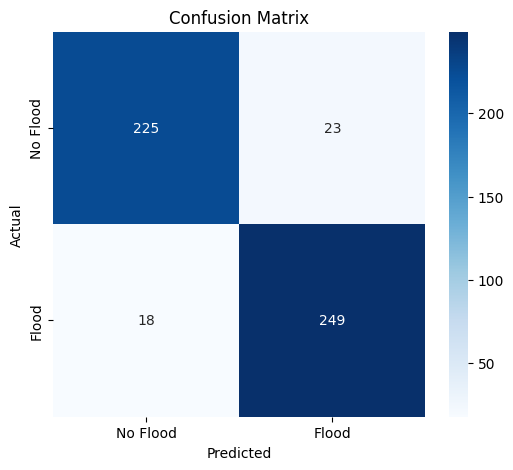

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ Predict labels
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# ✅ Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# ✅ Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [26]:
# Predict probabilities
y_prob = model.predict(X_test)

# Change threshold from 0.5 to 0.6 (or try 0.65, 0.7)
threshold = 0.6
y_pred = (y_prob > threshold).astype("int32")

# Evaluate again
print(classification_report(y_test, y_pred))


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       248
           1       0.93      0.92      0.92       267

    accuracy                           0.92       515
   macro avg       0.92      0.92      0.92       515
weighted avg       0.92      0.92      0.92       515



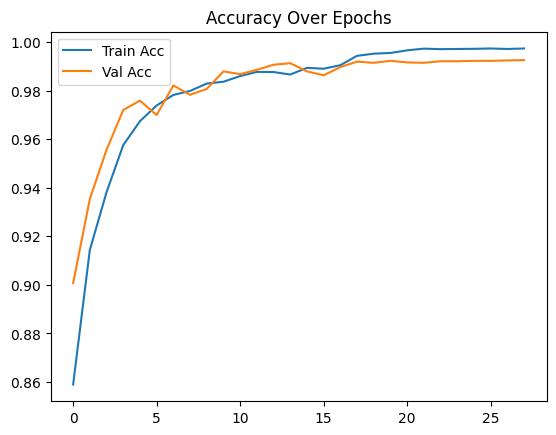

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


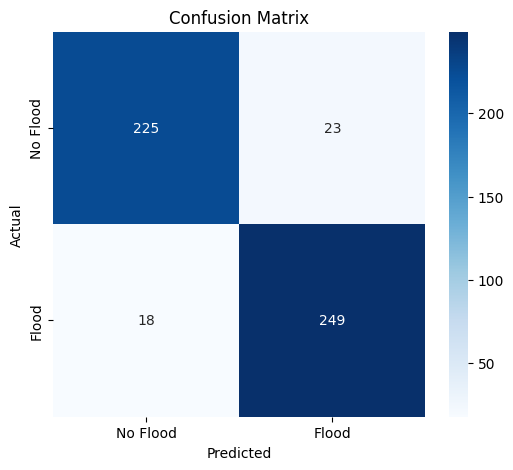

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ Predict labels
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# ✅ Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# ✅ Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [28]:
# Compare number of positives predicted before and after threshold change
y_pred_05 = (y_prob > 0.5).astype("int32")
y_pred_06 = (y_prob > 0.6).astype("int32")

print("Floods predicted at 0.5 threshold:", np.sum(y_pred_05))
print("Floods predicted at 0.6 threshold:", np.sum(y_pred_06))

# Compare confusion matrices
from sklearn.metrics import confusion_matrix

print("Confusion matrix at 0.5:")
print(confusion_matrix(y_test, y_pred_05))

print("Confusion matrix at 0.6:")
print(confusion_matrix(y_test, y_pred_06))


Floods predicted at 0.5 threshold: 272
Floods predicted at 0.6 threshold: 264
Confusion matrix at 0.5:
[[225  23]
 [ 18 249]]
Confusion matrix at 0.6:
[[229  19]
 [ 22 245]]


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


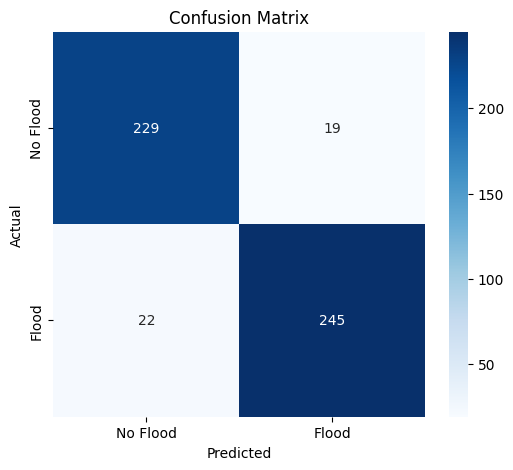

In [29]:
#False positive got reduced
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ Predict labels
y_pred = (model.predict(X_test) > 0.6).astype("int32")

# ✅ Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# ✅ Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [30]:
# 📦 Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import shap
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Step 2: Drop non-numeric or unwanted columns (like timestamp, IDs)
#df = df.drop(columns=['valid_time'])  # drop timestamp etc.

# ✅ Step 3: Features & Target
target_col = 'Flood_Occurred'
X = df.drop(columns=[target_col])
y = df[target_col]

# ✅ Step 4: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Step 5: Reshape for LSTM
# 🛠️ FIXED Time series reshaping logic
time_steps = 12

# Calculate n_samples and n_features such that total rows = time_steps * n_sequences
total_samples = X_scaled.shape[0]
usable_samples = (total_samples // time_steps) * time_steps  # make it divisible
X_trimmed = X_scaled[:usable_samples]
y_trimmed = y.values[:usable_samples]

X_seq = []
y_seq = []
for i in range(len(X_scaled) - time_steps):
    X_seq.append(X_scaled[i:i+time_steps])
    y_seq.append(y.values[i+time_steps-1])  # predict the last time step
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)


# ✅ Step 6: Align labels
y_seq = y.values[:X_seq.shape[0]]

# ✅ Step 7: SMOTE to handle class imbalance
X_flat = X_seq.reshape(X_seq.shape[0], -1)
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_flat, y_seq)

# ✅ Step 8: Reshape back to 3D
n_features = X_bal.shape[1] // time_steps

X_final = X_bal.reshape(X_bal.shape[0], time_steps, n_features)

# ✅ Step 9: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_bal, test_size=0.3, random_state=42)

# ✅ Step 10: Build LSTM Model
input_layer = Input(shape=(time_steps, n_features))
x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(32, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Step 11: Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)

# ✅ Step 12: Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=30, batch_size=32, callbacks=[early_stop, reduce_lr], verbose=1)

# ✅ Step 13: Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


Epoch 1/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8149 - loss: 0.4009 - val_accuracy: 0.9007 - val_loss: 0.2286 - learning_rate: 0.0010
Epoch 2/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9058 - loss: 0.2151 - val_accuracy: 0.9354 - val_loss: 0.1553 - learning_rate: 0.0010
Epoch 3/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9369 - loss: 0.1517 - val_accuracy: 0.9556 - val_loss: 0.1063 - learning_rate: 0.0010
Epoch 4/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9567 - loss: 0.1054 - val_accuracy: 0.9720 - val_loss: 0.0671 - learning_rate: 0.0010
Epoch 5/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9682 - loss: 0.0859 - val_accuracy: 0.9759 - val_loss: 0.0548 - learning_rate: 0.0010
Epoch 6/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9736 - loss: 0.0643 - val_accuracy: 0.9699 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 7/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9790 - los

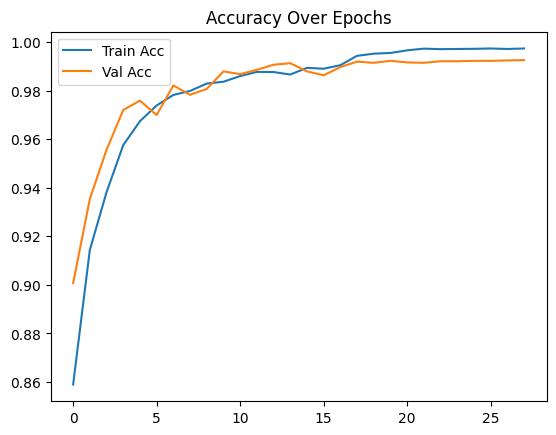

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()


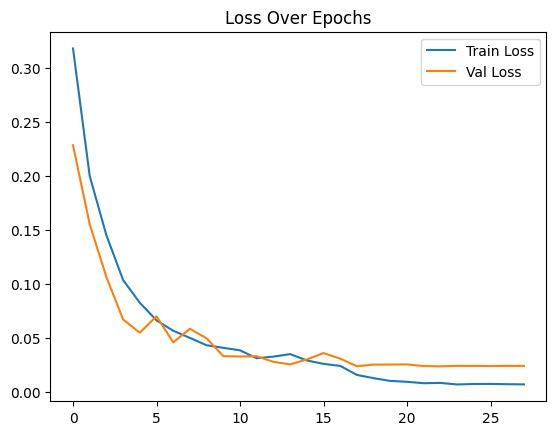

In [32]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()
